<a href="https://colab.research.google.com/github/Colsai/scott_data606/blob/main/data_preparation_eda/LDA_vis_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HHS OIG Workplan Topic Modeling
## Initial Test of LDA Modeling
- Looking through the current OIG work projects and group them using LDA.

## Specific Questions on Work Plan Projects
1) What does OIG cite as major focus areas (as topics)?  
2) Do those topics line up with major focus areas that OIG specifices on their website? 

### References
Link: https://zbib.org/d7adbbe5aea84033ae5c3d470692299b


### Works Cited
Kapadia, Shashank. “Topic Modeling in Python: Latent Dirichlet Allocation (LDA).” Medium, 29 Dec. 2020, https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0.

Kelechava, Marc. “Using LDA Topic Models as a Classification Model Input.” Medium, 6 Aug. 2020, https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28.

Khalid, Irfan Alghani. “Implement Your Topic Modeling Using The BERTopic Library.” Medium, 25 Jan. 2022, https://towardsdatascience.com/implement-your-topic-modeling-using-the-bertopic-library-d6708baa78fe.

“PyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know.” Neptune.Ai, 16 Nov. 2020, https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know.

Yadav, Kajal. “The Complete Practical Guide to Topic Modelling.” Medium, 22 Jan. 2022, https://towardsdatascience.com/topic-modelling-f51e5ebfb40a.


In [3]:
#Pip Install Missing Packages
!pip install pyLDAvis
!python -m spacy download en_core_web_md -qq
from IPython.display import clear_output
clear_output()

In [4]:
###########################
# Packages                #
###########################
import pandas as pd
import sklearn
import nltk
import spacy
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models
import en_core_web_md
import gensim
import random
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.test.utils import datapath
import warnings

warnings.filterwarnings('ignore')

# Set options for specific packages
nltk.download(['punkt', 
               'stopwords'])

# Visualise inside a notebook
pyLDAvis.enable_notebook()

sns.set()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
###########################
# Load CSVs (Github)      #
###########################
workplan_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_workplans.csv?raw=true")

#Drop typo column
workplan_df.drop(columns = 'Office of Evaluation and Inspections', 
                 inplace = True)

reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

In [8]:
'''
# Save model to disk.
def save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', 
               model = Lda_model):
    temp_file = datapath([path])
    model.save(temp_file)

# Load a potentially pretrained model from disk.
def load_model(path = ''):
    saved_model = LdaModel.load(path)
    return saved_model
'''

"\n# Save model to disk.\ndef save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', \n               model = Lda_model):\n    temp_file = datapath([path])\n    model.save(temp_file)\n\n# Load a potentially pretrained model from disk.\ndef load_model(path = ''):\n    saved_model = LdaModel.load(path)\n    return saved_model\n"

## EDA for workplan_df

In [9]:
workplan_df.columns

Index(['Announced or Revised', 'Agency', 'Title', 'Component',
       'Report Number(s)', 'Expected Issue Date (FY)', 'Website_Link',
       'Summary'],
      dtype='object')

In [10]:
#Are all titles unique?
workplan_df.Title.nunique() / len(workplan_df)

0.9648318042813455

In [11]:
#What are the statuses of all items?
workplan_df['Announced or Revised'].value_counts()

Completed              262
Revised                107
Completed (partial)     70
Nov-16                  29
Removed                 27
November 2021           13
February 2022           11
June 2021                8
December 2021            8
February 2020            6
January 2021             6
April 2021               6
May 2021                 6
January 2022             6
March 2022               6
August 2021              5
October 2017             5
July 2021                4
April 2022               4
May 2022                 4
December 2020            4
October 2020             4
June 2020                4
April 2020               3
August 2018              3
October 2021             3
August 2020              3
May 2020                 3
September 2021           2
November 2020            2
February 2021            2
June 2019                2
Complete                 2
December 2017            2
Jun-17                   2
February 2019            2
August 2019              2
D

In [12]:
workplan_df['Agency'].value_counts()

Centers for Medicare & Medicaid Services                                                                                                293
Centers for Medicare and Medicaid Services                                                                                              119
Administration for Children and Families                                                                                                 45
National Institutes of Health                                                                                                            26
Food and Drug Administration                                                                                                             20
Centers for Disease Control and Prevention                                                                                               18
Other                                                                                                                                    14
OS                  

In [13]:
#Are any products listed multiple times?
workplan_titles = workplan_df.Title.value_counts().reset_index()
workplan_titles.columns = ['Summary', 'Count']
workplan_titles[workplan_titles['Count'] > 1]

,Summary,Count
0,Ensuring Dual-Eligible Beneficiaries' Access t...,5
1,Superfund Financial Activities at the National...,3
2,Audit of the Food and Drug Administration's Pr...,2
3,Audit of Administration for Community Living's...,2
4,Office of Refugee Resettlement Influx Care Fac...,2
5,States' Oversight of Medicaid Managed Care Med...,2
6,Skilled Nursing Facility Reimbursement,2
7,NIH Oversight of Foreign Grant Recipients' Com...,2
8,Review of the Food and Drug Administration's C...,2
9,State Medicaid Fraud Control Units FY 2017 Ann...,2


In [14]:
#Check through EID (expected issue date)
workplan_df['Expected Issue Date (FY)'].value_counts()

2022                        229
2020                         90
2021                         74
2023                         66
2019                         62
2018                         62
2017                         27
Not Applicable               18
Annual                        3
2017, 2018                    2
2024                          2
FY 2021                       2
11-12-2021                    1
7/8/2021                      1
Every 6 months                1
Triennially                   1
2018, 2019                    1
11-18-2021                    1
Completed 2017                1
2019, 2020                    1
7/7/2021                      1
8/6/2021                      1
Completed (partial) 2017      1
10/18/2021                    1
Name: Expected Issue Date (FY), dtype: int64

In [15]:
#Check workplans by year (ignore all non-standardized years)
mask = [True if len(str(workplan)) == 4 else False 
        for workplan in workplan_df['Expected Issue Date (FY)']]

print("Expected Issue Date (FY) Year Values:")
workplan_df[mask]['Expected Issue Date (FY)'].value_counts()

Expected Issue Date (FY) Year Values:


2022    229
2020     90
2021     74
2023     66
2018     62
2019     62
2017     27
2024      2
Name: Expected Issue Date (FY), dtype: int64

In [16]:
workplan_df.Component.value_counts()[0:2]

Office of Audit Services                418
Office of Evaluation and Inspections    230
Name: Component, dtype: int64

In [17]:
workplan_df[workplan_df.Component == 'Office of Audit Services and Office of Evaluation and Inspections']

,Announced or Revised,Agency,Title,Component,Report Number(s),Expected Issue Date (FY),Website_Link,Summary
35,Nov-16,Centers for Medicare & Medicaid Services,Medicaid Payment Suspensions for Credible Alle...,Office of Audit Services and Office of Evaluat...,OEI-09-14-00020,2017,https://oig.hhs.gov/reports-and-publications/w...,Federal financial participation in Medicaid is...


In [18]:
workplan_df.Agency.value_counts()[0:5]

Centers for Medicare & Medicaid Services      293
Centers for Medicare and Medicaid Services    119
Administration for Children and Families       45
National Institutes of Health                  26
Food and Drug Administration                   20
Name: Agency, dtype: int64

## Topic Modeling for Workplan df
Look at topics of previous projects decided on

In [19]:
workplan_df.head()

,Announced or Revised,Agency,Title,Component,Report Number(s),Expected Issue Date (FY),Website_Link,Summary
0,Completed,Administration for Children and Families,States' Accuracy of Reporting TANF Spending In...,Office of Audit Services,A-02-17-02005; W-00-17-25100,2021,https://oig.hhs.gov/reports-and-publications/w...,The Temporary Assistance for Needy Families (T...
1,Completed,Administration for Children and Families,Head Start: Review of Single Audit Findings an...,Office of Audit Services,"A-02-16-02009, A-09-16-01004, A-06-17-07003;...",2018,https://oig.hhs.gov/reports-and-publications/w...,Effective for awards made on or after December...
2,Completed,Administration for Children and Families,Unaccompanied Children Program Grantee Reviews,Office of Audit Services,A-02-16-02013; A-04-16-03566; A-02-16-02007;...,2020,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
3,Nov-16,Administration for Children and Families,Recommendation Follow-Up: Office of Refugee Re...,Office of Evaluation and Inspections,OEI-09-16-00260,2017,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
4,October 2020,Administration for Children and Families,ACF Oversight of Guardian Ad Litem Requirement...,Office of Evaluation and Inspections,OEI-12-16-00120,2022,https://oig.hhs.gov/reports-and-publications/w...,As a condition of receiving Child Abuse Preven...


In [43]:
###########################
# Clean Data              #
###########################

from nltk.stem import RegexpStemmer

stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (asp and amp were relics of links within the page)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',
                  'oig',
                  'hhs',
                  'amp',
                  'asp'])

#Set tokenizer to additionally remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in workplan_df["Summary"]]

tokenized_sums = [[i for i in tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
workplan_df["summary_tokenized"] = tokenized_stemmed_sums

workplan_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

In [46]:
###############################
# LDA Data: Normal LDA        #
###############################

dictionary = Dictionary(workplan_df["summary_tokenized"])

#Filter extreme token values (no tokens below 5, no tokens in over 60% of documents)
dictionary.filter_extremes(no_below=5, 
                           no_above=0.5, 
                           keep_n=1000)

corpus = [dictionary.doc2bow(doc) for doc in workplan_df["summary_tokenized"]]

#lda model parameters
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=200, 
                         num_topics=14,
                         workers = 8, 
                         passes=20)

#Visualize the model with pyLDAvis
lda_model_visualize = pyLDAvis.gensim_models.prepare(lda_model,
                                                     corpus = corpus, 
                                                     dictionary = dictionary)
lda_model_visualize

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.110464  0.083938       1        1  14.368228
4     -0.157215  0.125774       2        1  13.131548
12     0.088336  0.090542       3        1  10.874670
3      0.241229 -0.050262       4        1   9.221977
7     -0.135444  0.030336       5        1   9.220426
13     0.097166  0.038213       6        1   7.816846
11    -0.073606  0.045930       7        1   7.788901
2      0.114212 -0.079678       8        1   6.264844
6      0.063333 -0.069024       9        1   5.636911
8      0.067004 -0.069319      10        1   4.100276
5     -0.135316  0.136998      11        1   3.453777
9     -0.210025 -0.257560      12        1   3.385222
10    -0.043102 -0.016503      13        1   2.378012
1     -0.027035 -0.009385      14        1   2.358362, topic_info=         Term        Freq       Total Category  logprob  loglift
235  medicare  939.000000  939.000000  Default  30.0000  30.0000
611    opioid  170.000000  170.000000  Default  29.0000  29.0000
161      drug  435.000000  435.000000  Default  28.0000  28.0000
168  medicaid  541.000000  541.000000  Default  27.0000  27.0000
41      state  729.000000  729.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
71     review   12.585350  426.683386  Topic14  -4.4668   0.2237
235  medicare   14.418923  939.566162  Topic14  -4.3308  -0.4297
59    federal   12.475424  493.443110  Topic14  -4.4756   0.0696
300      part   10.212880  354.863560  Topic14  -4.6757   0.1991
41      state    9.813440  729.746764  Topic14  -4.7156  -0.5617

[795 rows x 6 columns], token_table=      Topic      Freq Term
term                      
46        3  0.287333  000
46        5  0.143667  000
46        6  0.023944  000
46        8  0.047889  000
46       10  0.502833  000
...     ...       ...  ...
649       2  0.049287    ½
649       9  0.246433    ½
649      10  0.147860    ½
649      12  0.147860    ½
649      13  0.345006    ½

[2704 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 13, 4, 8, 14, 12, 3, 7, 9, 6, 10, 11, 2])

### What is 'part' and 'b'?
- https://www.medicare.gov/what-medicare-covers/what-part-b-covers

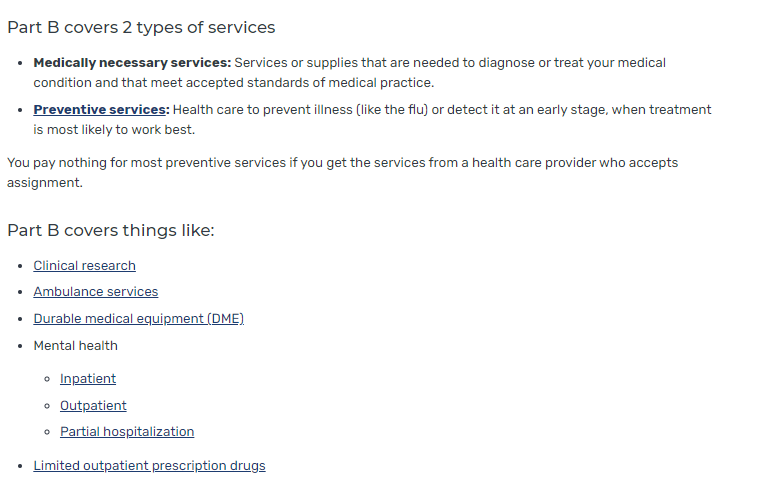

In [42]:
#Topics Generated
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.039*"drug" + 0.030*"price" + 0.026*"medicare" + 0.024*"amp" + 0.021*"report" + 0.019*"amount" + 0.017*"security" + 0.017*"reimbursement" + 0.017*"average" + 0.014*"test"
Topic: 1 
Words: 0.052*"part" + 0.039*"home" + 0.036*"drug" + 0.035*"medicare" + 0.022*"beneficiar" + 0.021*"hha" + 0.017*"prescription" + 0.016*"nurs" + 0.015*"resident" + 0.015*"cost"
Topic: 2 
Words: 0.031*"act" + 0.025*"program" + 0.020*"risk" + 0.016*"visit" + 0.015*"review" + 0.015*"requirement" + 0.012*"charge" + 0.012*"health" + 0.011*"compliance" + 0.010*"office"
Topic: 3 
Words: 0.039*"state" + 0.034*"federal" + 0.030*"health" + 0.023*"fund" + 0.021*"program" + 0.020*"grant" + 0.016*"nih" + 0.016*"requirement" + 0.011*"center" + 0.010*"care"
Topic: 4 
Words: 0.039*"data" + 0.027*"medicare" + 0.027*"opioid" + 0.024*"beneficiar" + 0.019*"cm" + 0.018*"risk" + 0.015*"identify" + 0.014*"part" + 0.014*"use" + 0.013*"health"
Topic: 5 
Words: 0.062*"medicare" + 0.044*"payment" + 0.035*"hospital" + 

In [25]:
#Check how it classifies

n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'], end = '')

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

Centers for Medicare &amp; Medicaid Services is responsible for ensuring that appropriate security controls have been implemented over States' Medicaid information systems.  Prior OIG audits reported that States lack sufficient security features, potentially exposing Medicaid beneficiary health information to unauthorized access.  We will determine whether the States safeguarded Medicaid data and supporting systems in accordance with Federal requirements.  We will review general controls and use OIG's automated assessment tools to assess controls for their information system networks, databases, and web-facing applications.
Score: 0.9189766049385071	 
Topic: 0.028*"drug" + 0.018*"federal" + 0.016*"fda" + 0.014*"hh" + 0.014*"review" + 0.014*"medicaid" + 0.013*"act" + 0.013*"program" + 0.012*"system" + 0.011*"amp"

Score: 0.06435280293226242	 
Topic: 0.072*"state" + 0.042*"medicaid" + 0.031*"care" + 0.028*"program" + 0.027*"federal" + 0.026*"provider" + 0.026*"payment" + 0.016*"health" +

## Coherence Model Score
Score Coherence of Model - u_mass coherence score

In [26]:
#LDA Model Coherence Score
cm = CoherenceModel(model=lda_model, 
                    corpus=corpus, 
                    coherence="u_mass")

coherence = cm.get_coherence()  # get coherence value

print(coherence)

-2.1752503683914077


## Tfidf Model
- Try a different model for calculating.

In [27]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=20, workers=8)

In [28]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.031*"asp" + 0.021*"price" + 0.014*"mfcu" + 0.014*"average" + 0.013*"quarter" + 0.011*"reimbursement" + 0.010*"drug" + 0.009*"sale" + 0.009*"amount" + 0.009*"amp"
Topic: 1 Word: 0.012*"hospital" + 0.010*"nurs" + 0.009*"home" + 0.009*"payment" + 0.009*"medicare" + 0.008*"inpatient" + 0.008*"hospice" + 0.008*"data" + 0.008*"fda" + 0.007*"care"
Topic: 2 Word: 0.050*"children" + 0.032*"orr" + 0.023*"foster" + 0.020*"unaccompanied" + 0.013*"refugee" + 0.012*"acf" + 0.010*"shelter" + 0.010*"resettlement" + 0.010*"custody" + 0.009*"famil"
Topic: 3 Word: 0.022*"financial" + 0.021*"statement" + 0.018*"dmepo" + 0.012*"manufacturer" + 0.011*"rebate" + 0.008*"audit" + 0.007*"prosthetic" + 0.007*"auditor" + 0.007*"paper" + 0.007*"audited"
Topic: 4 Word: 0.008*"state" + 0.007*"medicaid" + 0.007*"opioid" + 0.007*"drug" + 0.007*"medicare" + 0.006*"payment" + 0.006*"program" + 0.005*"provider" + 0.005*"health" + 0.005*"risk"
Topic: 5 Word: 0.020*"check" + 0.019*"background" + 0.015*"dua

In [29]:
#corpus = random.randint(0,len(corpus))
n = 300
print(workplan_df.iloc[n]['Summary'], end = '')
for index, score in sorted(lda_model_tfidf[corpus[n]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

Opioid abuse and overdose deaths are at crisis levels in the United States, with approximately 49,000 Americans dying from opioids in 2017, an increase from more than 42,000 in 2016.   Consistent with previous OIG work in Medicare Part D and Medicaid, we will determine the extent to which beneficiaries are receiving extreme amounts of opioids through Indian Health Service (IHS), as well as IHS-employed prescribers and IHS-run pharmacies that have questionable prescribing or dispensing patterns.  This review will also determine how IHS prevents and detects opioid misuse or abuse, as well as how it enforces its opioid-related policies.
Score: 0.8786152005195618	 
Topic: 0.008*"state" + 0.007*"medicaid" + 0.007*"opioid" + 0.007*"drug" + 0.007*"medicare" + 0.006*"payment" + 0.006*"program" + 0.005*"provider" + 0.005*"health" + 0.005*"risk"

Score: 0.10722329467535019	 
Topic: 0.042*"ih" + 0.020*"indian" + 0.013*"famil" + 0.013*"fmap" + 0.012*"incident" + 0.012*"child" + 0.011*"start" + 0.0

In [30]:
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.08032733781460998),
 (1, 0.06680720739964825),
 (2, 0.09129169023397705),
 (3, 0.3014371703370182),
 (4, 0.10750763877481936),
 (5, 0.0975324093123733),
 (6, 0.07958149937396115),
 (7, 0.14055324611860445),
 (8, 0.07958149937396115),
 (9, 0.06680720739964825),
 (10, 0.11986450085023498),
 (11, 0.09129169023397705),
 (12, 0.10207762237340029),
 (13, 0.07027662305930223),
 (14, 0.5171559088252629),
 (15, 0.14270484092135052),
 (16, 0.25582682754837544),
 (17, 0.09486684244312205),
 (18, 0.043921290159713654),
 (19, 0.07958149937396115),
 (20, 0.17840877449025908),
 (21, 0.07958149937396115),
 (22, 0.05115627371246922),
 (23, 0.11031683130214026),
 (24, 0.05036841079505216),
 (25, 0.06824174153246501),
 (26, 0.11986450085023498),
 (27, 0.07485289362938097),
 (28, 0.11986450085023498),
 (29, 0.0936236473738031),
 (30, 0.07485289362938097),
 (31, 0.07675029713657146),
 (32, 0.08714078579554667),
 (33, 0.1950648186247466),
 (34, 0.19233576186664642),
 (35, 0.05546744955815209),
 (36, 